# Notebook for testing Onnx with Sklearn

## Imports
___

In [1]:
import numpy as np
import pandas as pd
import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from tune_sklearn import TuneGridSearchCV
import seaborn as sns

import onnx
import onnxruntime as rt

In [2]:
%matplotlib inline

## Auxilary funktions
___

In [3]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = Int64TensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        k = k.replace(".","_")
        inputs.append((k, t))
    return inputs

## Import and Clean Dataset
___

In [4]:
data = pd.read_csv("../data/Data_Track2_1108.txt", sep=";")
data.append(pd.read_csv("../data/Data_Track0_1108.txt", sep=";"))
data.append(pd.read_csv("../data/Data_Track1_1108.txt", sep=";"))
data.head()

,Id,IsCrashed,MaxVelocity,Position.X,Position.Y,PreviousCheckpoint,Rotation,Score,ScoreOverall,Ticks,Velocity,Distance.Front,Distance.FrontLeft,Distance.FrontRight,Distance.Left,Distance.Right,stepCommand
0,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,290,0,511,45,49,43,45,0
1,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,291,0,511,45,49,43,45,0
2,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,292,0,511,45,49,43,45,0
3,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,292,0,511,45,49,43,45,0
4,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,293,0,511,45,49,43,45,0


In [5]:
 # clean crashes
crashes = np.array(data["IsCrashed"] == True)
filter_size = 7
kernel = np.ones(filter_size)
crashes = np.pad(crashes, (int(filter_size / 2), 0))

# window function
result = np.convolve(crashes, kernel, mode='same')[int(filter_size / 2)::]
result = result > 0

data["IsCrashed"] = result
data = data.loc[data["IsCrashed"] != True]
data = data.loc[data["stepCommand"] != 0]

#change datatype
data["Velocity"].replace(",",".", inplace=True, regex=True)
data["Velocity"] = pd.to_numeric(data["Velocity"])

data.head()

,Id,IsCrashed,MaxVelocity,Position.X,Position.Y,PreviousCheckpoint,Rotation,Score,ScoreOverall,Ticks,Velocity,Distance.Front,Distance.FrontLeft,Distance.FrontRight,Distance.Left,Distance.Right,stepCommand
28,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,317,0.000000,511,45,49,43,45,1
29,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5",650,100,0,0,0,0,318,0.000000,511,45,49,43,45,1
30,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5","650,16077",100,0,0,0,0,319,0.046785,511,45,49,43,45,1
31,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5","650,4135",100,0,0,0,0,320,0.094173,511,45,49,43,45,1
32,a2f3de66-eb6c-43ae-9574-c3c9acd35bc6,False,"0,5","650,8335",100,0,0,0,0,321,0.141261,511,45,49,43,45,1


In [6]:
data.drop(["Id", "IsCrashed", "MaxVelocity", "Position.X", "Position.Y", "PreviousCheckpoint", "Rotation",
         "Score", "ScoreOverall", "Ticks"], axis=1, inplace=True)
data.drop(data.tail(1).index, inplace=True)
data.head()

,Velocity,Distance.Front,Distance.FrontLeft,Distance.FrontRight,Distance.Left,Distance.Right,stepCommand
28,0.000000,511,45,49,43,45,1
29,0.000000,511,45,49,43,45,1
30,0.046785,511,45,49,43,45,1
31,0.094173,511,45,49,43,45,1
32,0.141261,511,45,49,43,45,1


In [7]:
# generate data X and labels y
X = data.drop("stepCommand", axis=1)
y = data["stepCommand"]

# generate train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=444)
X_train.dtypes

Velocity               float64
Distance.Front           int64
Distance.FrontLeft       int64
Distance.FrontRight      int64
Distance.Left            int64
Distance.Right           int64
dtype: object

In [8]:
data.describe()

,Velocity,Distance.Front,Distance.FrontLeft,Distance.FrontRight,Distance.Left,Distance.Right,stepCommand
count,24019.000000,24019.000000,24019.000000,24019.000000,24019.000000,24019.000000,24019.000000
mean,0.488920,174.955910,57.804488,83.806237,44.309130,42.640368,3.020067
std,0.059516,103.998202,56.444567,86.351574,23.166647,17.656677,2.325663
min,0.000000,32.000000,0.000000,2.000000,1.000000,9.000000,1.000000
25%,0.475975,102.000000,33.000000,37.000000,32.000000,33.000000,1.000000
50%,0.507807,139.000000,45.000000,51.000000,42.000000,41.000000,1.000000
75%,0.525795,216.000000,60.000000,78.000000,52.000000,49.000000,6.000000
max,0.548804,701.000000,741.000000,985.000000,285.000000,403.000000,6.000000


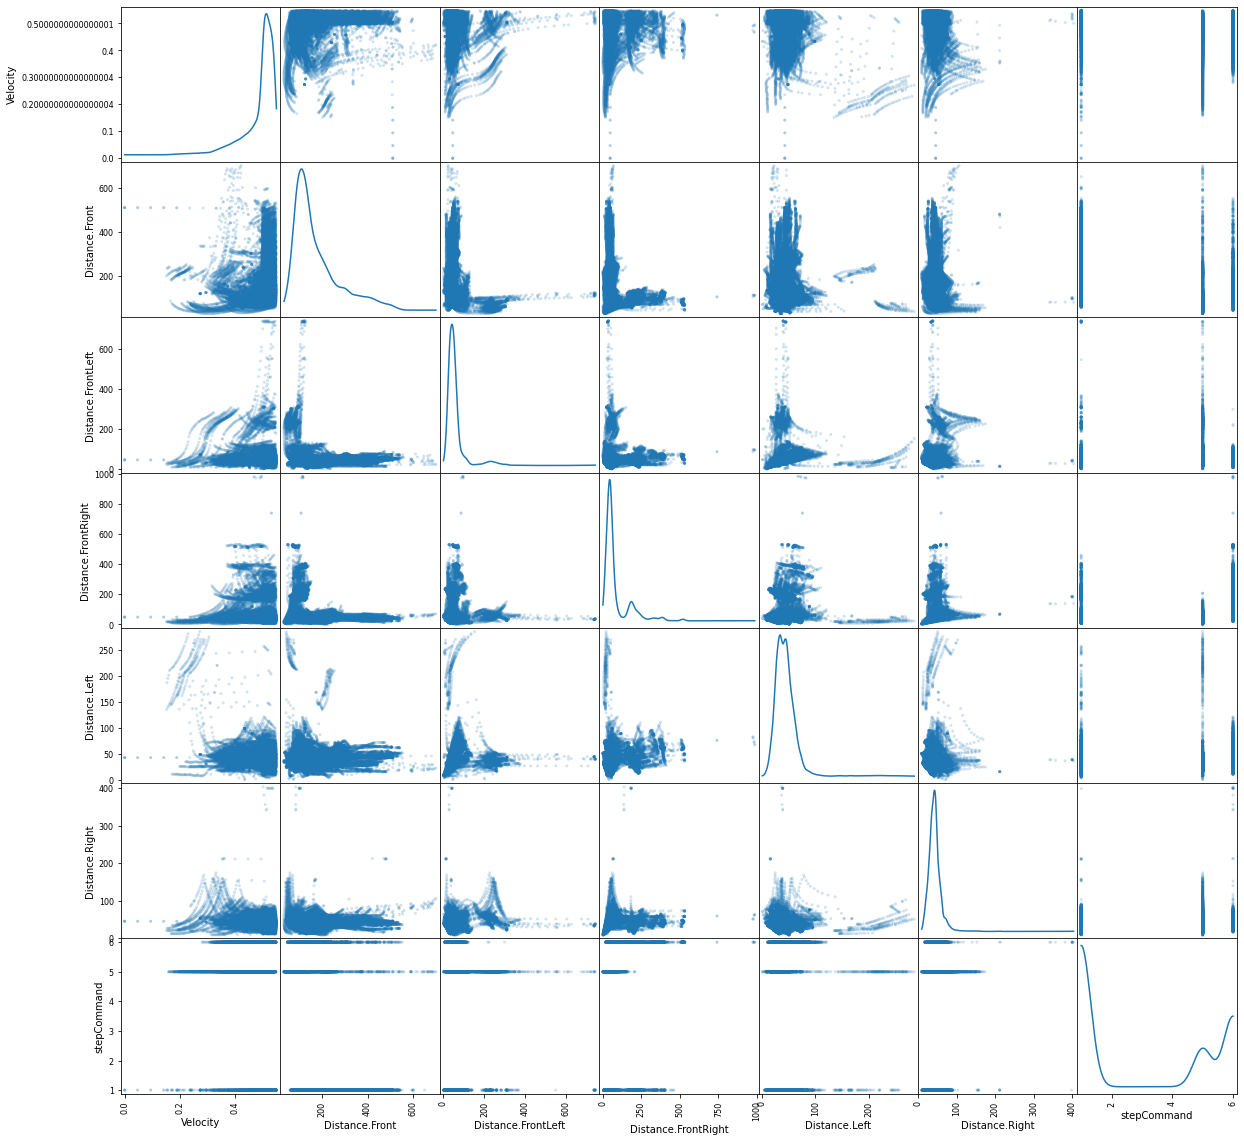

In [10]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal="kde",);

<AxesSubplot:>

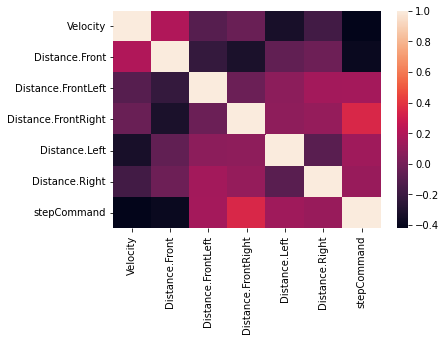

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()
sns.heatmap(corr)

## Bild Sklearn Classification Estimator
___

In [11]:
my_pipeline = make_pipeline(StandardScaler(),RandomForestClassifier())
my_pipeline = make_pipeline(StandardScaler(),LogisticRegression())
#my_pipeline = make_pipeline(RandomForestClassifier())
my_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [14]:
my_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [15]:
my_pipeline.score(X_test, Y_test)

0.7552039966694422

In [16]:
my_pipeline.predict(X_test)

array([6, 1, 1, ..., 6, 5, 1])

## Test PSA
___

In [37]:
from sklearn.decomposition import PCA
my_pipeline = make_pipeline(StandardScaler(), PCA(.50),LogisticRegression())
my_pca = make_pipeline(StandardScaler(), PCA(.50))
my_pca.fit(X_train, Y_train)
#my_pca.score(X_test, Y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.5))])

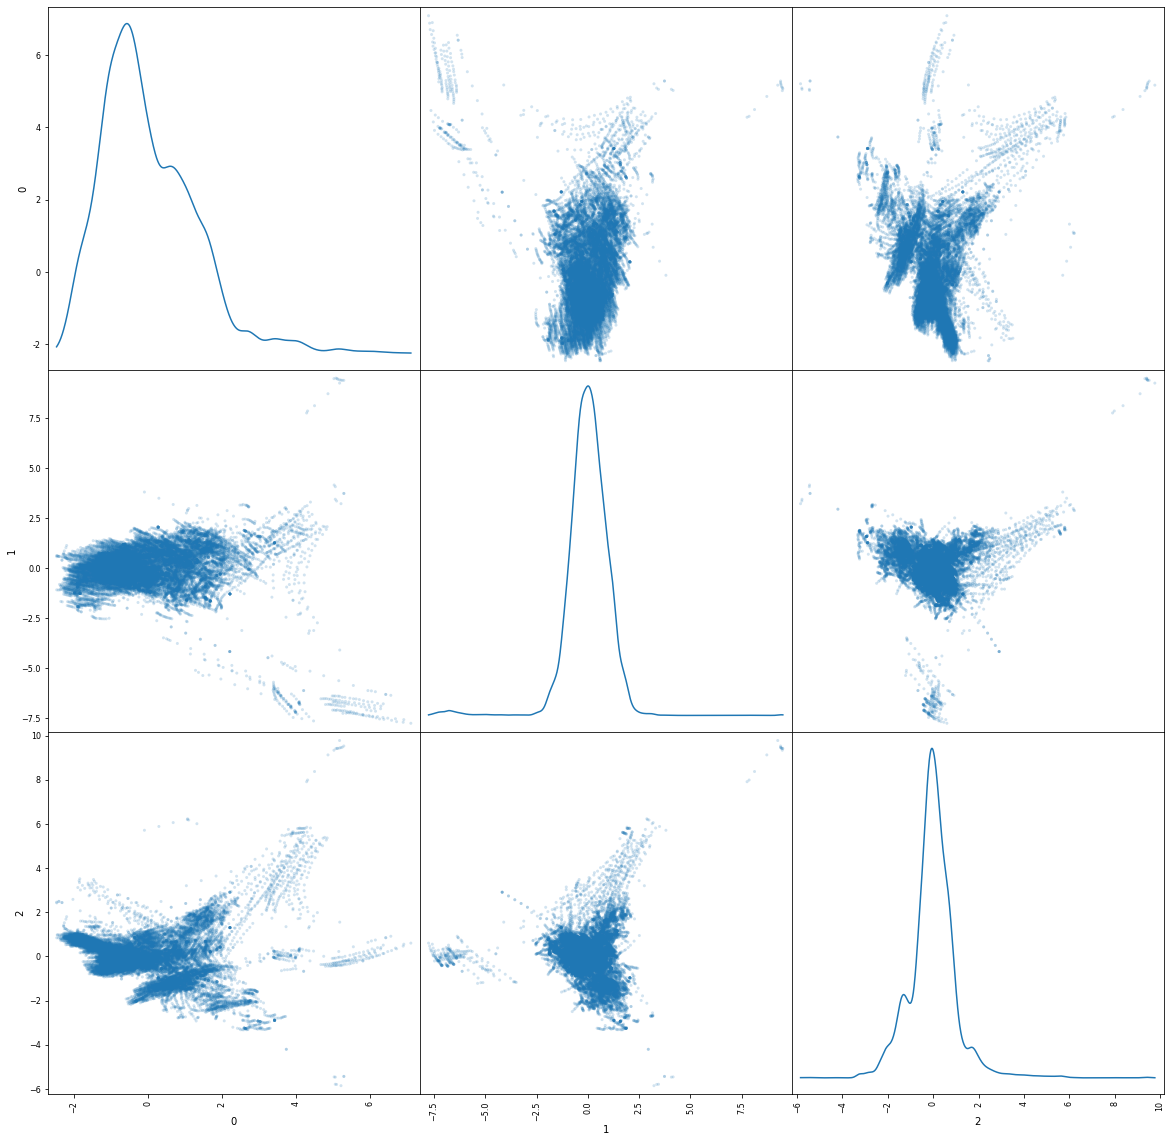

In [39]:
pca_data = pd.DataFrame(my_pca.transform(X))
pd.plotting.scatter_matrix(pca_data, alpha=0.2, figsize=(20, 20), diagonal="kde",);

In [28]:
my_pipeline[1].n_components_

AttributeError: 'PCA' object has no attribute 'n_components_'

## Convert to ONNX
___

In [18]:
initial_inputs = convert_dataframe_schema(X_train)

pprint.pprint(initial_inputs)

[('Velocity', FloatTensorType(shape=[None, 1])),
 ('Distance_Front', Int64TensorType(shape=[None, 1])),
 ('Distance_FrontLeft', Int64TensorType(shape=[None, 1])),
 ('Distance_FrontRight', Int64TensorType(shape=[None, 1])),
 ('Distance_Left', Int64TensorType(shape=[None, 1])),
 ('Distance_Right', Int64TensorType(shape=[None, 1]))]


In [19]:
initial_type = [('float_input', FloatTensorType([None, 1])),
                ('int_input', Int64TensorType([None, 5]))]
model_onnx = convert_sklearn(my_pipeline, 'pipeline_Owlracer', initial_inputs )


# And save.
with open("pipeline_owlracer.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [20]:
inputs = {c.replace(".","_"): X_test[c].values for c in X_test.columns}
inputs["Velocity"] = inputs["Velocity"].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))
inputs["Velocity"].shape

(7206, 1)

In [21]:
sess = rt.InferenceSession("pipeline_owlracer.onnx")
pred_onx = sess.run(None, inputs)

#print("predict", pred_onx[0])


In [22]:
from numpy.testing import assert_almost_equal
assert_almost_equal(my_pipeline.predict(X_test), pred_onx[0])